In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
years = np.arange(1980, 2025, 1)

In [3]:
df = None
for yr in years:
    file = pd.read_csv('Data/atp_matches_{}.csv'.format(yr))
    if df is None:
        df = file
    else:
        df = df.append(file, ignore_index=True)

In [4]:
df['tourney_name'] = df.tourney_name.str.upper()
df['year'] = pd.to_datetime(df['tourney_date'].astype(str), format='%Y%m%d').dt.year
df.sort_values(by=['tourney_date', 'tourney_name', 'match_num'], inplace=True)
# drop the carpet and Nan surface games. Carpet was mostly a thing pre 2000
df = df[df.surface.isin(['Clay', 'Hard', 'Grass'])] 

$\Huge Expected\;Score = \frac{1}{1 + 10^{\frac{ELO_B-ELO_A}{400}}}$

$\Huge ELO_{New} = ELO_{Old} + K * (Score - Expected)$

$\Huge K = \frac{250}{(Matches\;Played+5)^{0.4}}$

## Functions

In [5]:
starting_elo = 1500
elo_dict = {}
elo_dict_surface = {}
match_count_dict = {}
match_count_dict_surface = {}
last_game_dict = {}


def get_expected_score(elo_a, elo_b):
    return 1 / (1 + 10**((elo_b-elo_a)/400))

def compute_k(match_count, level):
    k = 250/((match_count+5)**0.4)
    if level=='G':
        k*=1.1
    return k

def compute_elo_penalty(player_name, elo_current, tourney_date):
    # penalize large breaks in career for high ranked players. Lower ranked players tend to drop off ATP circuit
    date_last_played = last_game_dict.get(player_name, tourney_date)
    days_since_last_game = (datetime.strptime(str(tourney_date), '%Y%m%d') - datetime.strptime(str(date_last_played), '%Y%m%d')).days
    
    winter_break = False
    current_month = datetime.strptime(str(tourney_date), '%Y%m%d').month
    current_year = datetime.strptime(str(tourney_date), '%Y%m%d').year
    last_played_month = datetime.strptime(str(date_last_played), '%Y%m%d').month
    last_played_year = datetime.strptime(str(date_last_played), '%Y%m%d').year
    
    # if break spans year end and is at most 3 months long we assume it is Winter Break rather than an actual break
    if current_year == last_played_year+1:
        months_missed = sorted(list(np.arange(last_played_month+1, 12+1, 1)) + list(np.arange(1,current_month,1)))
        if len(months_missed)<=3 & (months_missed.count(11)>0 or months_missed.count(12)>0):
            winter_break=True
    
    if elo_current > 1900 and not winter_break:
        if days_since_last_game > 56:
            penalty = 100
        elif days_since_last_game > 150:
            penalty = 150
        else:
            penalty = 0
    else:
        penalty = 0
    return penalty
    
    
def get_new_elo(elo_current, score, expected, match_count, level):   
    k = compute_k(match_count, level)
    return elo_current + k*(score-expected)

def get_current_elo(player_name, tourney_date, surface=None):
    if surface:
        elo = elo_dict_surface.get((player_name, surface), starting_elo)
    else:
        elo = elo_dict.get(player_name, starting_elo)
        
    penalty = compute_elo_penalty(player_name, elo, tourney_date)
    
    return elo-penalty

def get_win_rate_grouped(df, groupby='surface'):
    if isinstance(groupby, str):
        groupby = [groupby]
    
    players_wins_df = df.loc[df.winner_name.isin(players)].copy()
    players_wins_df['opponent'] = df.loser_name
    wins_by_surface = players_wins_df[['winner_name', 'tourney_date'] + groupby].groupby(by=['winner_name'] + groupby, as_index=False).count().sort_values(by='tourney_date', ascending=False)
    wins_by_surface.rename(columns={'tourney_date': 'wins', 'winner_name': 'player'}, inplace=True)
    
    players_loss_df = df.loc[df.loser_name.isin(players)].copy()
    players_loss_df['opponent'] = df.winner_name
    loss_by_surface = players_loss_df[['loser_name', 'tourney_date'] + groupby].groupby(by=['loser_name'] + groupby, as_index=False).count().sort_values(by='tourney_date', ascending=False)
    loss_by_surface.rename(columns={'tourney_date': 'losses', 'loser_name': 'player'}, inplace=True)
    
    merged = pd.merge(wins_by_surface, loss_by_surface, on=['player'] + groupby, how='outer')
    merged.fillna(0, inplace=True)
    merged['matches'] = merged.wins + merged.losses
    merged['win_rate'] = round(merged.wins * 100 / merged.matches,2)
    merged.sort_values(by='win_rate', ascending=False, inplace=True)
    merged.reset_index(inplace=True, drop=True)
    
    return merged

for _, row in df.iterrows():
    winner_elo_current = get_current_elo(row.winner_name, row.tourney_date)
    loser_elo_current = get_current_elo(row.loser_name, row.tourney_date)
    
    winner_expected_score = get_expected_score(
        winner_elo_current, loser_elo_current
    )
    loser_expected_score = get_expected_score(loser_elo_current, winner_elo_current)
    
    winner_elo_new = get_new_elo(
        winner_elo_current, 1, winner_expected_score, match_count_dict.get(row.winner_name, 0), row.tourney_level
    )
    loser_elo_new = get_new_elo(
        loser_elo_current, 0, loser_expected_score, match_count_dict.get(row.loser_name, 0), row.tourney_level
    )
    
    df.at[_, 'winner_elo'] = round(winner_elo_new,0)
    df.at[_, 'loser_elo'] = round(loser_elo_new,0)
    elo_dict[row.winner_name] = round(winner_elo_new,0)
    elo_dict[row.loser_name] = round(loser_elo_new,0)
    
    w_elo_surface = get_current_elo(row.winner_name, row.tourney_date, row.surface)
    l_elo_surface = get_current_elo(row.loser_name, row.tourney_date, row.surface)
    w_surface_es = get_expected_score(w_elo_surface, l_elo_surface)
    l_surface_es = get_expected_score(l_elo_surface, w_elo_surface)
    w_new_elo_surface = get_new_elo(
        w_elo_surface, 1, w_surface_es, match_count_dict_surface.get((row.winner_name, row.surface), 0), row.tourney_level
    )
    l_new_elo_surface = get_new_elo(
        l_elo_surface, 0, l_surface_es, match_count_dict_surface.get((row.loser_name, row.surface), 0), row.tourney_level
    )
  
    df.at[_, 'w_elo_{}'.format(row.surface.lower())] = round(w_new_elo_surface,0)
    df.at[_, 'l_elo_{}'.format(row.surface.lower())] = round(l_new_elo_surface,0)
    elo_dict_surface[(row.winner_name, row.surface)] = round(w_new_elo_surface,0)
    elo_dict_surface[(row.loser_name, row.surface)] = round(l_new_elo_surface,0)
    
    match_count_dict[row.winner_name] = match_count_dict.get(row.winner_name, 0)+1
    match_count_dict[row.loser_name] = match_count_dict.get(row.loser_name, 0)+1
    match_count_dict_surface[(row.winner_name, row.surface)] = match_count_dict_surface.get((row.winner_name, row.surface), 0)+1
    match_count_dict_surface[(row.loser_name, row.surface)] = match_count_dict_surface.get((row.loser_name, row.surface), 0)+1
    
    last_game_dict[row.winner_name] = row.tourney_date
    last_game_dict[row.loser_name] = row.tourney_date
    
for surface in ['clay', 'grass', 'hard']:
    for side in ['w', 'l']:
        df['{}_elo_{}'.format(side, surface)].fillna(method='ffill', inplace=True)

## Constants

In [6]:
grand_slam_df = df.loc[df.tourney_level=='G'].copy()
gs_df_condensed = grand_slam_df[['year', 'tourney_name', 'tourney_date', 'surface', 'round',
                                 'winner_name', 'loser_name',
                                 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
                                 'winner_elo', 'loser_elo', 'w_elo_hard', 'l_elo_hard',
                                 'w_elo_grass', 'l_elo_grass', 'w_elo_clay', 'l_elo_clay'
                                ]].copy()

players = [
    'Roger Federer', 'Novak Djokovic', 'Rafael Nadal'
    # ,'Andy Murray'
]  
players_df = gs_df_condensed.loc[gs_df_condensed.winner_name.isin(players) | 
                            gs_df_condensed.loser_name.isin(players)].copy()

## Win Rates

In [7]:
rows_list = []
for p in players:
    p_df = players_df.loc[(players_df.winner_name == p) | (players_df.loser_name == p)].copy()
    p_df['Result'] = ['Won' if (x == p) else 'Lost' for x in p_df.winner_name]
    
    total_matches = len(p_df)
    total_won = p_df.Result.value_counts()['Won']
    win_rate = round(100*total_won / total_matches,2)
    
    summary_dict = {'Player': p, 'Matches': total_matches, 'Won': total_won, 'Win Rate': win_rate}
    rows_list.append(summary_dict)
    
summary_df = pd.DataFrame(rows_list, columns=['Player', 'Matches', 'Won', 'Win Rate'])
summary_df.set_index('Player', inplace=True)
summary_df.sort_values(by='Win Rate', ascending=False)

,Matches,Won,Win Rate
Player,,,
Novak Djokovic,417,368,88.25
Rafael Nadal,360,315,87.50
Roger Federer,434,373,85.94


In [8]:
get_win_rate_grouped(players_df, groupby='surface')

,player,surface,wins,losses,matches,win_rate
0,Rafael Nadal,Clay,112,4,116,96.55
1,Novak Djokovic,Grass,92,11,103,89.32
2,Novak Djokovic,Hard,183,22,205,89.27
3,Roger Federer,Grass,106,14,120,88.33
4,Roger Federer,Hard,194,29,223,87.00
5,Novak Djokovic,Clay,93,16,109,85.32
6,Rafael Nadal,Hard,145,28,173,83.82
7,Rafael Nadal,Grass,58,13,71,81.69
8,Roger Federer,Clay,73,18,91,80.22


In [9]:
big3_games_df = players_df.loc[df.winner_name.isin(players) & df.loser_name.isin(players)]
big3_finals_df = big3_games_df.loc[big3_games_df['round']=='F']

In [10]:
get_win_rate_grouped(big3_games_df, groupby='opponent')

,player,opponent,wins,losses,matches,win_rate
0,Rafael Nadal,Roger Federer,10,4,14,71.43
1,Novak Djokovic,Roger Federer,11,6,17,64.71
2,Rafael Nadal,Novak Djokovic,11,7,18,61.11
3,Novak Djokovic,Rafael Nadal,7,11,18,38.89
4,Roger Federer,Novak Djokovic,6,11,17,35.29
5,Roger Federer,Rafael Nadal,4,10,14,28.57


In [11]:
win_rates_by_year = get_win_rate_grouped(players_df, groupby='year').sort_values(by=['year', 'win_rate'], ascending=True).reset_index(drop=True)
wrby_condensed = pd.merge(
    pd.merge(win_rates_by_year[['year', 'win_rate']].loc[(win_rates_by_year.player=='Roger Federer')], 
         win_rates_by_year[['year', 'win_rate']].loc[win_rates_by_year.player=='Rafael Nadal'],
         on='year', how='outer', suffixes=('_rf', '_rn')),
    win_rates_by_year[['year', 'win_rate']].loc[win_rates_by_year.player=='Novak Djokovic'],
    on='year', how='outer', suffixes=('', '_nd'),
)

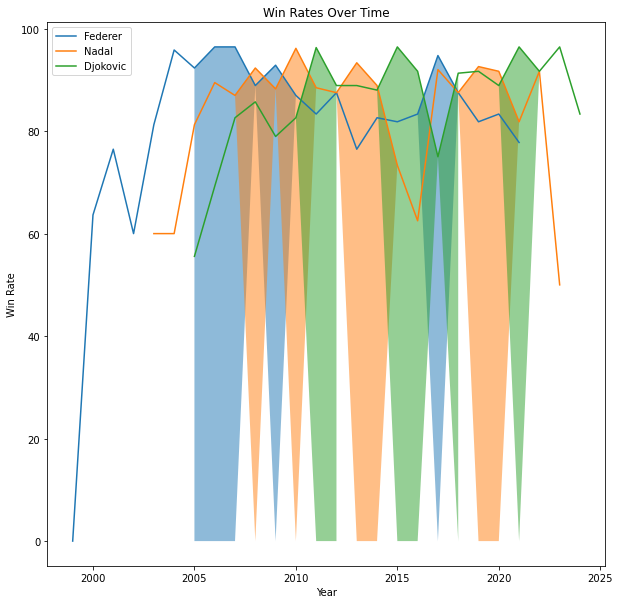

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(wrby_condensed.year, wrby_condensed.win_rate_rf, label='Federer')
ax.plot(wrby_condensed.year, wrby_condensed.win_rate_rn, label='Nadal')
ax.plot(wrby_condensed.year, wrby_condensed.win_rate, label='Djokovic')

ax.fill_between(wrby_condensed.year, wrby_condensed.win_rate_rf, 
                where=(wrby_condensed.win_rate_rf>=wrby_condensed.win_rate_rn)&
                      (wrby_condensed.win_rate_rf>=wrby_condensed.win_rate),
                alpha=0.5,
                interpolate=True
               )
ax.fill_between(wrby_condensed.year, wrby_condensed.win_rate_rn, 
                where=(wrby_condensed.win_rate_rn>=wrby_condensed.win_rate_rf)&
                      (wrby_condensed.win_rate_rn>=wrby_condensed.win_rate),
                alpha=0.5,
                interpolate=True
               )
ax.fill_between(wrby_condensed.year, wrby_condensed.win_rate, 
                where=(wrby_condensed.win_rate>=wrby_condensed.win_rate_rf)&
                      (wrby_condensed.win_rate>=wrby_condensed.win_rate_rn),
                alpha=0.5,
                interpolate=True
               )

ax.set_title('Win Rates Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Win Rate')
ax.legend()


In [13]:
win_rates_by_year_h2h = get_win_rate_grouped(df=big3_games_df, groupby='year').sort_values(by='year', ascending=True).reset_index(drop=True)
wrby_h2h_condensed = pd.merge(
    pd.merge(win_rates_by_year_h2h[['year', 'win_rate']].loc[(win_rates_by_year_h2h.player=='Roger Federer')], 
         win_rates_by_year_h2h[['year', 'win_rate']].loc[win_rates_by_year_h2h.player=='Rafael Nadal'],
         on='year', how='outer', suffixes=('_rf', '_rn')),
    win_rates_by_year_h2h[['year', 'win_rate']].loc[win_rates_by_year_h2h.player=='Novak Djokovic'],
    on='year', how='outer', suffixes=('', '_nd'),
)
wrby_h2h_condensed.sort_values(by='year', ascending=True, inplace=True)

wrby_h2h_condensed.reset_index(inplace=True, drop=True)
wrby_h2h_condensed.fillna(0, inplace=True)

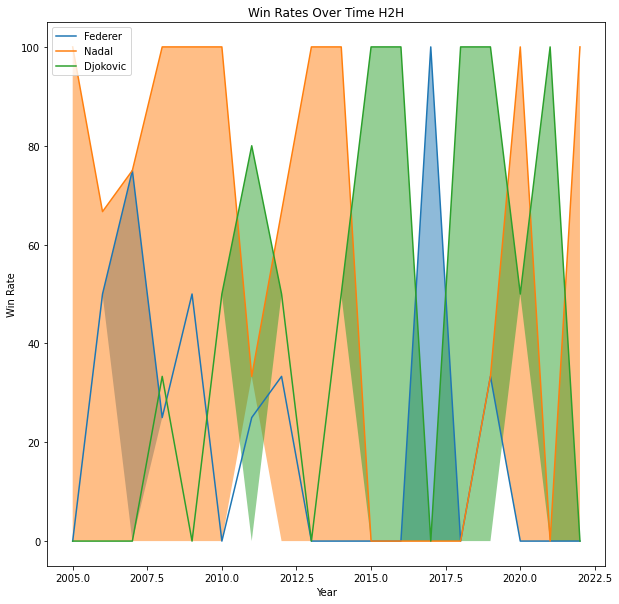

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(wrby_h2h_condensed.year, wrby_h2h_condensed.win_rate_rf, label='Federer')
ax.plot(wrby_h2h_condensed.year, wrby_h2h_condensed.win_rate_rn, label='Nadal')
ax.plot(wrby_h2h_condensed.year, wrby_h2h_condensed.win_rate, label='Djokovic')

ax.fill_between(wrby_h2h_condensed.year, wrby_h2h_condensed.win_rate_rf, 
                where=(wrby_h2h_condensed.win_rate_rf>=wrby_h2h_condensed.win_rate_rn)&
                      (wrby_h2h_condensed.win_rate_rf>=wrby_h2h_condensed.win_rate),
                alpha=0.5,
                interpolate=True
               )
ax.fill_between(wrby_h2h_condensed.year, wrby_h2h_condensed.win_rate_rn, 
                where=(wrby_h2h_condensed.win_rate_rn>=wrby_h2h_condensed.win_rate_rf)&
                      (wrby_h2h_condensed.win_rate_rn>=wrby_h2h_condensed.win_rate),
                alpha=0.5,
                interpolate=True
               )
ax.fill_between(wrby_h2h_condensed.year, wrby_h2h_condensed.win_rate, 
                where=(wrby_h2h_condensed.win_rate>=wrby_h2h_condensed.win_rate_rf)&
                      (wrby_h2h_condensed.win_rate>=wrby_h2h_condensed.win_rate_rn),
                alpha=0.5,
                interpolate=True
               )

ax.set_title('Win Rates Over Time H2H')
ax.set_xlabel('Year')
ax.set_ylabel('Win Rate')
ax.legend()


In [109]:
finals_df = gs_df_condensed.loc[(gs_df_condensed['round']=='F')&(gs_df_condensed.winner_name.isin(players))].copy()
wins_per_year_df = finals_df[['year', 'winner_name', 'round']].groupby(['year', 'winner_name'], as_index=False).count()
wins_per_year_df['total_wins'] = wins_per_year_df.groupby(['winner_name'], as_index=False)['round'].cumsum()

total_wins_condensed = pd.merge(
    pd.merge(wins_per_year_df[['year', 'total_wins']].loc[wins_per_year_df.winner_name=='Roger Federer'], 
         wins_per_year_df[['year', 'total_wins']].loc[wins_per_year_df.winner_name=='Rafael Nadal'],
         on='year', how='outer', suffixes=('_rf', '_rn')),
    wins_per_year_df[['year', 'total_wins']].loc[wins_per_year_df.winner_name=='Novak Djokovic'],
    on='year', how='outer', suffixes=('', '_nd'),
)
total_wins_condensed.sort_values(by='year', ascending=True, inplace=True)
total_wins_condensed.reset_index(inplace=True, drop=True)
total_wins_condensed.fillna(method='ffill', inplace=True)

slope_years = 1
total_wins_condensed['rf_slope'] = (
    total_wins_condensed.total_wins_rf - total_wins_condensed.total_wins_rf.shift(slope_years)
) / slope_years

total_wins_condensed['rn_slope'] = (
    total_wins_condensed.total_wins_rn - total_wins_condensed.total_wins_rn.shift(slope_years)
) / slope_years

total_wins_condensed['nd_slope'] = (
    total_wins_condensed.total_wins - total_wins_condensed.total_wins.shift(slope_years)
) / slope_years

total_wins_condensed.fillna(0, inplace=True)

In [110]:
total_wins_condensed

,year,total_wins_rf,total_wins_rn,total_wins,rf_slope,rn_slope,nd_slope
0,2003,1.0,0.0,0.0,0.0,0.0,0.0
1,2004,4.0,0.0,0.0,3.0,0.0,0.0
2,2005,6.0,1.0,0.0,2.0,0.0,0.0
3,2006,9.0,2.0,0.0,3.0,1.0,0.0
4,2007,12.0,3.0,0.0,3.0,1.0,0.0
5,2008,13.0,5.0,1.0,1.0,2.0,0.0
6,2009,15.0,6.0,1.0,2.0,1.0,0.0
7,2010,16.0,9.0,1.0,1.0,3.0,0.0
8,2011,16.0,10.0,4.0,0.0,1.0,3.0
9,2012,17.0,11.0,5.0,1.0,1.0,1.0


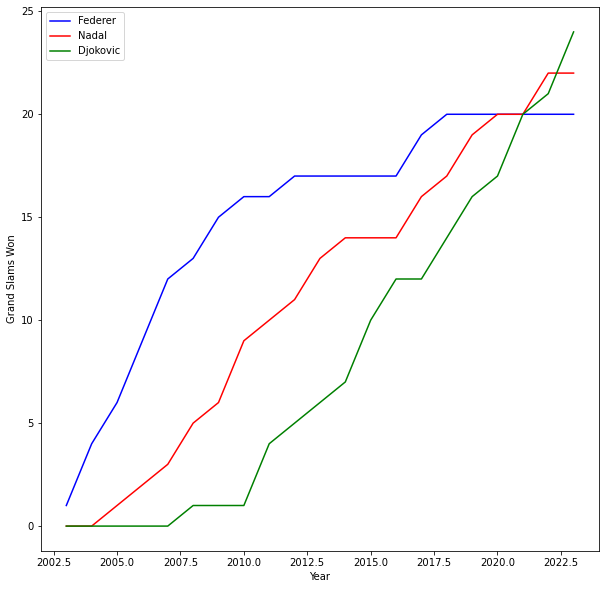

In [120]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(total_wins_condensed.year, total_wins_condensed.total_wins_rf, label='Federer', color='b')
ax.plot(total_wins_condensed.year, total_wins_condensed.total_wins_rn, label='Nadal', color='r')
ax.plot(total_wins_condensed.year, total_wins_condensed.total_wins, label='Djokovic', color='g')
# ax.set_xticklabels(total_wins_condensed.year.astype(int))
#ax.set_title('Grand Slams')
ax.set_ylabel('Grand Slams Won')
ax.set_xlabel('Year')

# ax.fill_between(total_wins_condensed.year, total_wins_condensed.total_wins_rf, 
#                 where=(total_wins_condensed.total_wins_rf>total_wins_condensed.total_wins_rn)&
#                       (total_wins_condensed.total_wins_rf>total_wins_condensed.total_wins),
#                 alpha=0.2,
#                 interpolate=True, color='b'
#                )

# # ax.fill_between(total_wins_condensed.year, total_wins_condensed.total_wins_rf, 
# #                 where=total_wins_condensed.year<2008,
# #                 alpha=0.5,
# #                 interpolate=False, color='b'
# #                )

# ax.fill_between(total_wins_condensed.year, total_wins_condensed.total_wins_rn, 
#                 where=(total_wins_condensed.total_wins_rn>total_wins_condensed.total_wins_rf)&
#                       (total_wins_condensed.total_wins_rn>total_wins_condensed.total_wins),
#                 alpha=0.5,
#                 interpolate=True, color='r'
#                )

# ax.fill_between(total_wins_condensed.year, total_wins_condensed.total_wins, 
#                 where=(total_wins_condensed.total_wins>total_wins_condensed.total_wins_rf)&
#                       (total_wins_condensed.total_wins>total_wins_condensed.total_wins_rn),
#                 alpha=0.5,
#                 interpolate=True, color='g'
#                )

ax.legend()

## Elo Ratings

In [17]:
final_df = gs_df_condensed.loc[(gs_df_condensed['round']=='F')]
final_df = final_df[final_df.year>2002].copy()
winners_df = final_df[['year', 'tourney_name', 'winner_name']].copy()
winners_path_df = pd.merge(winners_df, gs_df_condensed, on=['year', 'tourney_name', 'winner_name'])
winners_path_df.loser_rank_points.fillna(0, inplace=True)

tourney_elos_df = winners_path_df[['year', 'tourney_name', 'winner_name', 'winner_elo', 'loser_elo']].groupby(by=['year', 'tourney_name', 'winner_name'], as_index=False).mean()
tourney_elos_df['total_avg_opponent_elo'] = tourney_elos_df.loser_elo.mean()
tourney_elos_df['tourney_route_difficulty'] = tourney_elos_df.loser_elo / tourney_elos_df.total_avg_opponent_elo
avg_route_df = tourney_elos_df[['winner_name', 'tourney_route_difficulty']].groupby(by='winner_name', as_index=False).mean()
avg_route_df.rename(columns={'tourney_route_difficulty':'Avg Score'}, inplace=True)
count_df = tourney_elos_df[['winner_name', 'tourney_route_difficulty']].groupby(by='winner_name', as_index=False).count()
count_df.rename(columns={'tourney_route_difficulty':'Total Wins'}, inplace=True)
summary = pd.merge(avg_route_df, count_df, on='winner_name').sort_values(by='Total Wins', ascending=False).reset_index(drop=True)
summary['Difficulty Adjusted Wins'] = summary['Avg Score'] * summary['Total Wins']
summary = summary.round(decimals=2)

grass_df = winners_path_df.loc[winners_path_df.surface=='Grass'][['year', 'tourney_name', 'surface', 'winner_name', 'loser_elo', 'l_elo_grass']].groupby(by=['year', 'tourney_name', 'surface', 'winner_name'], as_index=False).mean()
grass_df.rename(columns={'l_elo_grass':'loser_elo_surface'}, inplace=True)
clay_df = winners_path_df.loc[winners_path_df.surface=='Clay'][['year', 'tourney_name', 'surface', 'winner_name', 'loser_elo', 'l_elo_clay']].groupby(by=['year', 'tourney_name', 'surface', 'winner_name'], as_index=False).mean()
clay_df.rename(columns={'l_elo_clay':'loser_elo_surface'}, inplace=True)
hard_df = winners_path_df.loc[winners_path_df.surface=='Hard'][['year', 'tourney_name', 'surface', 'winner_name', 'loser_elo', 'l_elo_hard']].groupby(by=['year', 'tourney_name', 'surface', 'winner_name'], as_index=False).mean()
hard_df.rename(columns={'l_elo_hard':'loser_elo_surface'}, inplace=True)

surfaces_df = pd.concat([grass_df, clay_df, hard_df])
surface_avg_elos = surfaces_df[['surface', 'loser_elo_surface']].groupby('surface', as_index=False).mean()
surface_avg_elos.rename(columns={'loser_elo_surface':'surface_avg_opp_elo'}, inplace=True)
surfaces_new = pd.merge(surfaces_df, surface_avg_elos, on='surface')
surfaces_new['tourney_route_difficulty_surface'] = surfaces_new.loser_elo_surface / surfaces_new.surface_avg_opp_elo
surfaces_new = surfaces_new[['winner_name', 'tourney_route_difficulty_surface']].groupby('winner_name', as_index=False).sum().sort_values(by='tourney_route_difficulty_surface', ascending=False)
surfaces_new = surfaces_new.round(decimals=2)

pd.merge(summary, surfaces_new, on='winner_name')

,winner_name,Avg Score,Total Wins,Difficulty Adjusted Wins,tourney_route_difficulty_surface
0,Novak Djokovic,1.00,24,23.99,24.01
1,Rafael Nadal,1.00,22,22.01,21.97
2,Roger Federer,1.00,20,19.94,20.01
3,Andy Murray,1.01,3,3.02,3.02
4,Stan Wawrinka,1.02,3,3.07,3.06
5,Carlos Alcaraz,1.01,2,2.01,1.98
6,Andre Agassi,0.99,1,0.99,0.99
7,Andy Roddick,1.01,1,1.01,1.00
8,Daniil Medvedev,0.98,1,0.98,0.97
9,Dominic Thiem,0.94,1,0.94,0.95


In [63]:
tourney_counts = tourney_elos_df[tourney_elos_df.winner_name.isin(players)]
tourney_counts.rename(columns={'year': 'Total Wins'}, inplace=True)
tourney_counts[['winner_name', 'tourney_name', 'Total Wins']].groupby(by=['winner_name', 'tourney_name'], as_index=False).count().sort_values(by='Total Wins', ascending=False)

C:\Users\devli\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,winner_name,tourney_name,Total Wins
5,Rafael Nadal,ROLAND GARROS,14
0,Novak Djokovic,AUSTRALIAN OPEN,10
11,Roger Federer,WIMBLEDON,8
3,Novak Djokovic,WIMBLEDON,7
8,Roger Federer,AUSTRALIAN OPEN,6
10,Roger Federer,US OPEN,5
2,Novak Djokovic,US OPEN,4
6,Rafael Nadal,US OPEN,4
1,Novak Djokovic,ROLAND GARROS,3
4,Rafael Nadal,AUSTRALIAN OPEN,2


In [121]:
summary

,winner_name,Avg Score,Total Wins,Difficulty Adjusted Wins
0,Novak Djokovic,1.00,24,23.99
1,Rafael Nadal,1.00,22,22.01
2,Roger Federer,1.00,20,19.94
3,Andy Murray,1.01,3,3.02
4,Stan Wawrinka,1.02,3,3.07
5,Carlos Alcaraz,1.01,2,2.01
6,Andre Agassi,0.99,1,0.99
7,Andy Roddick,1.01,1,1.01
8,Daniil Medvedev,0.98,1,0.98
9,Dominic Thiem,0.94,1,0.94


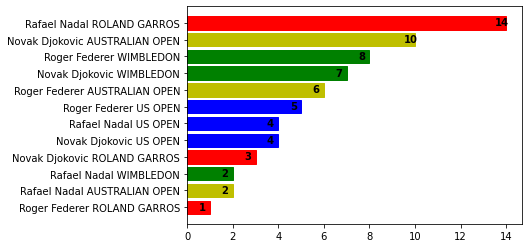

In [81]:
plotdf = tourney_counts[['winner_name', 'tourney_name', 'Total Wins']].groupby(by=['winner_name', 'tourney_name'], as_index=False).count().sort_values(by='Total Wins', ascending=True)
plotdf['Label'] = plotdf.winner_name + ' ' + plotdf.tourney_name

fig, ax = plt.subplots()

barlist = ax.barh(plotdf.Label, plotdf['Total Wins'])

barlist[0].set_color('r')
barlist[1].set_color('y')
barlist[2].set_color('g')
barlist[3].set_color('r')
barlist[4].set_color('b')
barlist[5].set_color('b')
barlist[6].set_color('b')
barlist[7].set_color('y')
barlist[8].set_color('g')
barlist[9].set_color('g')
barlist[10].set_color('y')
barlist[11].set_color('r')

# barlist[0].set_color('g')
# barlist[1].set_color('r')
# barlist[2].set_color('r')
# barlist[3].set_color('y')
# barlist[4].set_color('y')
# barlist[5].set_color('r')
# barlist[6].set_color('g')
# barlist[7].set_color('g')
# barlist[8].set_color('y')
# barlist[9].set_color('g')
# barlist[10].set_color('y')
# barlist[11].set_color('r')

for i, v in enumerate(plotdf['Total Wins']):
    ax.text(v-0.5, i-0.15, str(v), 
            color = 'black', fontweight = 'bold')

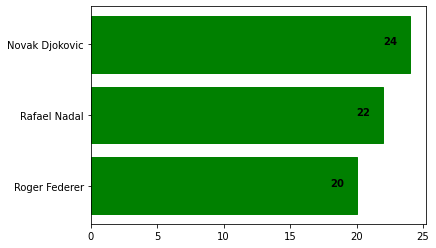

In [62]:
plotdf = tourney_counts[['winner_name', 'Total Wins']].groupby(by=['winner_name'], as_index=False).count().sort_values(by='Total Wins', ascending=True)

fig, ax = plt.subplots()

barlist = ax.barh(plotdf.winner_name, plotdf['Total Wins'])

barlist[0].set_color('g')
barlist[1].set_color('g')
barlist[2].set_color('g')

for i, v in enumerate(plotdf['Total Wins']):
    ax.text(v-2, i, str(v), 
            color = 'black', fontweight = 'bold')

In [19]:
tourney_elos_df.sort_values(by='tourney_route_difficulty')

,year,tourney_name,winner_name,winner_elo,loser_elo,total_avg_opponent_elo,tourney_route_difficulty
70,2020,US OPEN,Dominic Thiem,1935.571429,1761.142857,1866.534014,0.943536
58,2017,US OPEN,Rafael Nadal,2065.285714,1797.857143,1866.534014,0.963206
81,2023,US OPEN,Novak Djokovic,2109.714286,1797.857143,1866.534014,0.963206
62,2018,US OPEN,Novak Djokovic,2131.714286,1805.000000,1866.534014,0.967033
69,2020,ROLAND GARROS,Rafael Nadal,2044.428571,1809.714286,1866.534014,0.969559
12,2006,AUSTRALIAN OPEN,Roger Federer,2259.142857,1812.285714,1866.534014,0.970936
74,2021,WIMBLEDON,Novak Djokovic,2019.142857,1813.571429,1866.534014,0.971625
71,2021,AUSTRALIAN OPEN,Novak Djokovic,2028.142857,1822.571429,1866.534014,0.976447
73,2021,US OPEN,Daniil Medvedev,2053.285714,1822.857143,1866.534014,0.976600
65,2019,ROLAND GARROS,Rafael Nadal,2069.285714,1824.285714,1866.534014,0.977365


In [20]:
winners_path_df[winners_path_df.winner_name=='Novak Djokovic']

,year,tourney_name,winner_name,tourney_date,surface,round,loser_name,winner_rank,winner_rank_points,loser_rank,loser_rank_points,winner_elo,loser_elo,w_elo_hard,l_elo_hard,w_elo_grass,l_elo_grass,w_elo_clay,l_elo_clay
140,2008,AUSTRALIAN OPEN,Novak Djokovic,20080114,Hard,R128,Benjamin Becker,3.0,4315.0,81.0,496.0,2073.0,1630.0,2038.0,1636.0,1597.0,1332.0,1934.0,1829.0
141,2008,AUSTRALIAN OPEN,Novak Djokovic,20080114,Hard,R64,Simone Bolelli,3.0,4315.0,70.0,541.0,2075.0,1610.0,2041.0,1561.0,1597.0,1332.0,1934.0,1829.0
142,2008,AUSTRALIAN OPEN,Novak Djokovic,20080114,Hard,R32,Sam Querrey,3.0,4315.0,62.0,588.0,2079.0,1708.0,2047.0,1710.0,1597.0,1332.0,1934.0,1829.0
143,2008,AUSTRALIAN OPEN,Novak Djokovic,20080114,Hard,R16,Lleyton Hewitt,3.0,4315.0,22.0,1385.0,2086.0,1830.0,2058.0,1849.0,1597.0,1332.0,1934.0,1829.0
144,2008,AUSTRALIAN OPEN,Novak Djokovic,20080114,Hard,QF,David Ferrer,3.0,4315.0,5.0,2615.0,2102.0,2033.0,2077.0,1989.0,1597.0,1332.0,1934.0,1829.0
145,2008,AUSTRALIAN OPEN,Novak Djokovic,20080114,Hard,SF,Roger Federer,3.0,4315.0,1.0,7180.0,2129.0,2291.0,2111.0,2261.0,1597.0,1332.0,1934.0,1829.0
146,2008,AUSTRALIAN OPEN,Novak Djokovic,20080114,Hard,F,Jo-Wilfried Tsonga,3.0,4315.0,38.0,789.0,2140.0,1980.0,2125.0,1951.0,1597.0,1332.0,1934.0,1829.0
224,2011,AUSTRALIAN OPEN,Novak Djokovic,20110117,Hard,R128,Marcel Granollers,3.0,6240.0,42.0,993.0,2149.0,1749.0,2153.0,1694.0,1572.0,1357.0,1871.0,1751.0
225,2011,AUSTRALIAN OPEN,Novak Djokovic,20110117,Hard,R64,Ivan Dodig,3.0,6240.0,81.0,606.0,2152.0,1772.0,2156.0,1748.0,1572.0,1357.0,1871.0,1751.0
226,2011,AUSTRALIAN OPEN,Novak Djokovic,20110117,Hard,R32,Viktor Troicki,3.0,6240.0,27.0,1490.0,2158.0,1938.0,2163.0,1932.0,1572.0,1357.0,1871.0,1751.0


In [21]:
winners_path_df.loc[(winners_path_df.year==2018)&(winners_path_df.tourney_name=='AUSTRALIAN OPEN')]

,year,tourney_name,winner_name,tourney_date,surface,round,loser_name,winner_rank,winner_rank_points,loser_rank,loser_rank_points,winner_elo,loser_elo,w_elo_hard,l_elo_hard,w_elo_grass,l_elo_grass,w_elo_clay,l_elo_clay
420,2018,AUSTRALIAN OPEN,Roger Federer,20180115,Hard,R128,Aljaz Bedene,2.0,9605.0,51.0,968.0,2087.0,1709.0,2198.0,1606.0,1555.0,1401.0,1961.0,1694.0
421,2018,AUSTRALIAN OPEN,Roger Federer,20180115,Hard,R64,Jan Lennard Struff,2.0,9605.0,55.0,870.0,2089.0,1741.0,2199.0,1733.0,1555.0,1401.0,1961.0,1694.0
422,2018,AUSTRALIAN OPEN,Roger Federer,20180115,Hard,R32,Richard Gasquet,2.0,9605.0,31.0,1375.0,2092.0,1826.0,2201.0,1845.0,1555.0,1401.0,1961.0,1694.0
423,2018,AUSTRALIAN OPEN,Roger Federer,20180115,Hard,R16,Marton Fucsovics,2.0,9605.0,80.0,674.0,2094.0,1795.0,2202.0,1743.0,1555.0,1401.0,1961.0,1694.0
424,2018,AUSTRALIAN OPEN,Roger Federer,20180115,Hard,QF,Tomas Berdych,2.0,9605.0,20.0,2050.0,2097.0,1827.0,2204.0,1867.0,1555.0,1401.0,1961.0,1694.0
425,2018,AUSTRALIAN OPEN,Roger Federer,20180115,Hard,SF,Hyeon Chung,2.0,9605.0,58.0,857.0,2102.0,1959.0,2208.0,1946.0,1555.0,1401.0,1961.0,1694.0
426,2018,AUSTRALIAN OPEN,Roger Federer,20180115,Hard,F,Marin Cilic,2.0,9605.0,6.0,3805.0,2107.0,1981.0,2211.0,1925.0,1555.0,1401.0,1961.0,1694.0


In [22]:
winners_path_df.loc[(winners_path_df.year==2018)&(winners_path_df.tourney_name=='AUSTRALIAN OPEN')].loser_elo.mean()

1834.0

In [122]:
tourney_points_df = winners_path_df.loc[(winners_path_df.year>2002)].copy() # ranking points system has changed over time
# tourney_points_df = winners_path_df.loc[(winners_path_df.year>2008)&(winners_path_df.year<2024)].copy()
tourney_points_df = tourney_points_df[['year', 'tourney_name', 'winner_name', 'winner_rank_points', 'loser_rank_points']].groupby(by=['year', 'tourney_name', 'winner_name'], as_index=False).mean()
tourney_points_df['total_avg_opponent_points'] = tourney_points_df.loser_rank_points.mean()
tourney_points_df['tourney_route_difficulty'] = tourney_points_df.loser_rank_points / tourney_points_df.total_avg_opponent_points

avg_points_df = tourney_points_df[['winner_name', 'tourney_route_difficulty']].groupby(by='winner_name', as_index=False).mean()
avg_points_df.rename(columns={'tourney_route_difficulty':'Avg Score'}, inplace=True)
count_df = tourney_points_df[['winner_name', 'tourney_route_difficulty']].groupby(by='winner_name', as_index=False).count()
count_df.rename(columns={'tourney_route_difficulty':'Total Wins'}, inplace=True)
summary_p = pd.merge(avg_points_df, count_df, on='winner_name').sort_values(by='Total Wins', ascending=False).reset_index(drop=True)
summary_p['Difficulty Adjusted Wins'] = summary_p['Avg Score'] * summary_p['Total Wins']
summary_p = summary_p.round(decimals=2)
summary_p

,winner_name,Avg Score,Total Wins,Difficulty Adjusted Wins
0,Novak Djokovic,1.10,24,26.39
1,Rafael Nadal,1.04,22,22.83
2,Roger Federer,0.74,20,14.82
3,Andy Murray,1.06,3,3.17
4,Stan Wawrinka,1.72,3,5.17
5,Carlos Alcaraz,1.07,2,2.14
6,Andre Agassi,0.38,1,0.38
7,Andy Roddick,0.61,1,0.61
8,Daniil Medvedev,1.19,1,1.19
9,Dominic Thiem,0.91,1,0.91


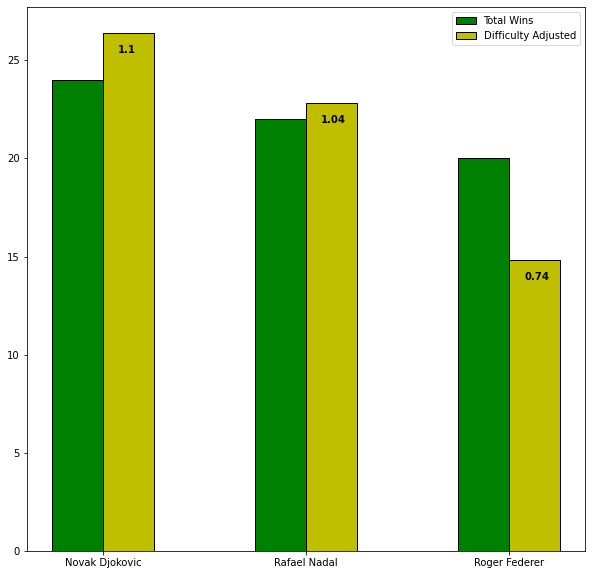

In [163]:
summary_p.sort_values(by='Total Wins', inplace=True, ascending=False)

plotdf = summary_p[summary_p.winner_name.isin(players)]

fig, ax = plt.subplots(figsize=(10,10))

n=3
r=np.arange(n)
width=0.25

barlist = ax.bar(r, plotdf['Total Wins'], width=width, 
                 label='Total Wins', color='g', edgecolor='black')
otherbarlist = ax.bar(r+width, plotdf['Difficulty Adjusted Wins'], width=width, label='Difficulty Adjusted', 
                      color='y', edgecolor='black')

# barlist[0].set_color('g')
# barlist[1].set_color('g')
# barlist[2].set_color('g')

labesl = list(summary_p['Avg Score'])

for i, v in enumerate(plotdf['Difficulty Adjusted Wins']):
    ax.text(i+0.2, v-1, str(labesl[i]), 
            color = 'black', fontweight = 'bold')

plt.xticks(r + width/2,['Novak Djokovic', 'Rafael Nadal', 'Roger Federer']) 

ax.legend()

In [24]:
player = 'Tony Giammalva'

wins = df[['year', 'tourney_date', 'winner_rank_points', 'winner_elo']].loc[df.winner_name==player].copy()
wins.rename(columns={'winner_rank_points':'rank_points', 'winner_elo':'elo'}, inplace=True)

losses = df[['year', 'tourney_date', 'loser_rank_points', 'loser_elo']].loc[df.loser_name==player].copy()
losses.rename(columns={'loser_rank_points':'rank_points', 'loser_elo':'elo'}, inplace=True)

merged = pd.concat([wins, losses])
merged.sort_values(by='tourney_date', ascending=True, inplace=True)
merged.reset_index(drop=True, inplace=True)

merged['ELO Change'] = merged.elo - merged.elo.shift(1)

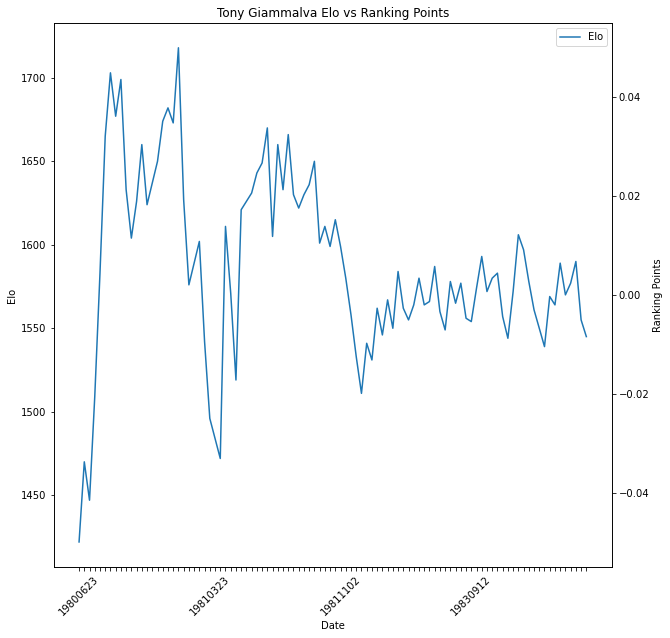

In [25]:
## plot ELO vs Ranking points over time
fig, ax = plt.subplots(figsize=(10,10))

ax2 = ax.twinx()

ax.plot(merged.index, merged.elo, label='Elo')
ax2.plot(merged.index, merged.rank_points, label='Rank Points', color='r')

ax.set_title('{} Elo vs Ranking Points'.format(player))
ax.set_xlabel('Date')
ax.set_ylabel('Elo')
ax2.set_ylabel('Ranking Points')
ax.set_xticks(merged.index)
ax.set_xticklabels(merged.tourney_date, rotation=45)
ax.legend()

for num, label in enumerate(ax.xaxis.get_ticklabels()):
    if num % 25 != 0:
        label.set_visible(False)

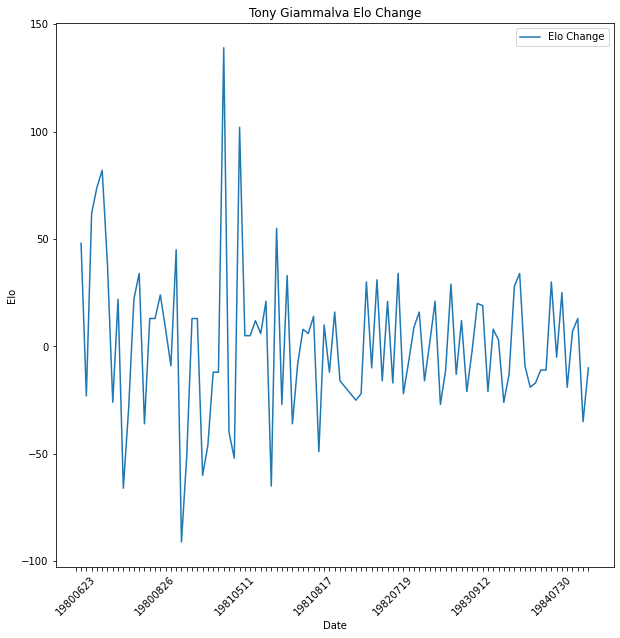

In [26]:
## plot ELO Change over time
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(merged.index, merged['ELO Change'], label='Elo Change')

ax.set_title('{} Elo Change'.format(player))
ax.set_xlabel('Date')
ax.set_ylabel('Elo')
ax.set_xticks(merged.index)
ax.set_xticklabels(merged.tourney_date, rotation=45)
ax.legend()

for num, label in enumerate(ax.xaxis.get_ticklabels()):
    if num % 15 != 0:
        label.set_visible(False)

In [27]:
wins = df.loc[df.winner_name==player].copy()
wins['Result'] = ['W']*len(wins)
wins['ELO'] = wins.winner_elo
losses = df.loc[df.loser_name==player].copy()
losses['Result'] = ['L']*len(losses)
losses['ELO'] = losses.loser_elo
merged = pd.concat([wins, losses])
merged.sort_values(by='tourney_date', inplace=True)
merged.reset_index(drop=True, inplace=True)
merged['ELO Change'] = merged.ELO - merged.ELO.shift(1)
merged['Days Since'] = (pd.to_datetime(merged['tourney_date'].astype(str), format='%Y%m%d') - pd.to_datetime(merged['tourney_date'].astype(str), format='%Y%m%d').shift(1)).dt.days
merged[['tourney_name', 'surface', 'tourney_date', 'winner_name', 'loser_name',
        'winner_elo', 'loser_elo', 'Result', 'ELO', 'ELO Change', 'Days Since']]

,tourney_name,surface,tourney_date,winner_name,loser_name,winner_elo,loser_elo,Result,ELO,ELO Change,Days Since
0,WIMBLEDON,Grass,19800623,Jan Kodes,Tony Giammalva,1533.0,1422.0,L,1422.0,NaN,NaN
1,GSTAAD,Clay,19800707,Tony Giammalva,Colin Dowdeswell,1470.0,1313.0,W,1470.0,48.0,14.0
2,GSTAAD,Clay,19800707,Heinz Gunthardt,Tony Giammalva,1725.0,1447.0,L,1447.0,-23.0,0.0
3,BASTAD,Clay,19800714,Tony Giammalva,Hans Simonsson,1509.0,1432.0,W,1509.0,62.0,7.0
4,BASTAD,Clay,19800714,Tony Giammalva,Christophe Roger Vasselin,1583.0,1610.0,W,1583.0,74.0,0.0
5,BASTAD,Clay,19800714,Tony Giammalva,Heinz Gunthardt,1665.0,1793.0,W,1665.0,82.0,0.0
6,BASTAD,Clay,19800714,Tony Giammalva,Paul Kronk,1703.0,1562.0,W,1703.0,38.0,0.0
7,BASTAD,Clay,19800714,Balazs Taroczy,Tony Giammalva,1881.0,1677.0,L,1677.0,-26.0,0.0
8,HILVERSUM,Clay,19800721,Tony Giammalva,Patrick Proisy,1699.0,1467.0,W,1699.0,22.0,7.0
9,HILVERSUM,Clay,19800721,Per Hjertquist,Tony Giammalva,1568.0,1633.0,L,1633.0,-66.0,0.0


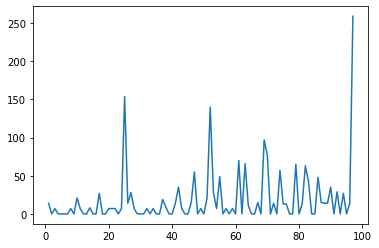

In [28]:
plt.plot(merged.index, merged['Days Since'])

In [29]:
df[df.winner_name=='Emilio Sanchez'][['tourney_name', 'tourney_date', 'match_num', 'winner_name', 'loser_name']]

,tourney_name,tourney_date,match_num,winner_name,loser_name
15546,BARI,19840402,3,Emilio Sanchez,Marcos Hocevar
15561,BARI,19840402,18,Emilio Sanchez,Jimmy Brown
15568,BARI,19840402,25,Emilio Sanchez,Andreas Maurer
15518,NICE,19840409,6,Emilio Sanchez,Ronald Agenor
15531,NICE,19840409,19,Emilio Sanchez,Mel Purcell
18495,DAVIS CUP EUR R1: ESP VS ALG,19840504,1,Emilio Sanchez,Kamel Harrad
18497,DAVIS CUP EUR R1: ESP VS ALG,19840504,4,Emilio Sanchez,Yassine Amier
17783,ROLAND GARROS,19840528,23,Emilio Sanchez,Marcos Hocevar
17836,ROLAND GARROS,19840528,76,Emilio Sanchez,Tomas Smid
17862,ROLAND GARROS,19840528,102,Emilio Sanchez,Roland Stadler


In [35]:
df[['tourney_name', 'tourney_date', 'winner_name', 'winner_elo', 'round', 'loser_name', 'loser_elo']].sort_values(by='winner_elo', ascending=False)

,tourney_name,tourney_date,winner_name,winner_elo,round,loser_name,loser_elo
124135,DUBAI,20160222,Novak Djokovic,2410.0,R16,Malek Jaziri,1591.0
124127,DUBAI,20160222,Novak Djokovic,2410.0,R32,Tommy Robredo,1806.0
123825,AUSTRALIAN OPEN,20160118,Novak Djokovic,2409.0,F,Andy Murray,2189.0
124855,ROME MASTERS,20160509,Novak Djokovic,2408.0,SF,Kei Nishikori,2113.0
124482,MIAMI MASTERS,20160321,Novak Djokovic,2407.0,F,Kei Nishikori,2084.0
125201,WIMBLEDON,20160627,Novak Djokovic,2405.0,R128,James Ward,1505.0
124481,MIAMI MASTERS,20160321,Novak Djokovic,2405.0,SF,David Goffin,1977.0
123823,AUSTRALIAN OPEN,20160118,Novak Djokovic,2405.0,SF,Roger Federer,2235.0
125265,WIMBLEDON,20160627,Novak Djokovic,2405.0,R64,Adrian Mannarino,1756.0
125037,ROLAND GARROS,20160523,Novak Djokovic,2405.0,F,Andy Murray,2209.0
